<table>
<tr>    
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
<td style="text-align: center">
<h1>Sequential data training using<br />1D ConvNet and Recurrent Neural Networks</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index-eng.php">Adrian Horzyk</a></h2>
<h3>Welcome to the interactive lecture where you can check everything by yourself and experiment!</h3>
</td> 
</tr>
</table>

# Sequence Processing with 1D Convnets

Sequencial data are usually processed using recurrent neural networks (RNNs) of various kinds (e.g. GRU or LSTM), transformers (e.g. BERT) or using deep reinforcement learning (DRL), but sometimes we can also use 1D convnets when the data sequence is not so essencial as the occurrence of the elements or the resolution of sequental data is too high. One of such problems is the IMDB sentiment classification task where the positive or negative classification depends more on the used words in the sentences than on the sequential relationships.

In [1]:
#Install necessary libraries if necessary
#!python -m pip install tensorflow==2.10
#!python -m pip install keras==2.10
#!python -m pip install matplotlib
#!python -m pip install numpy
#!python -m pip install seaborn
#!python -m pip install pandas
#!python -m pip install cv2
#!python -m pip install scikit-learn
#!python -m pip install scikitplot

In [1]:
import tensorflow as tf
import keras
print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

TensorFlow version: 2.8.1
Keras version: 2.8.0


In [3]:
# pip install tensorflow-gpu
# https://www.tensorflow.org/guide/gpu
#gpus = tf.config.list_physical_devices('GPU')
#if gpus:
  # Restrict TensorFlow to only use the first GPU
#  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
#    print(e)

#tf.device("/gpu:0")
#tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available()

## Set up the model directory for saving the trained models

In [3]:
import os

# The path to store trained models
models_dir = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Data/nlp/model'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

## Definition of plotting functions

First, let's define plotting functions that will be used to chart the plots of the achieved results:

In [4]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

#def plt_inline():
#    rc = plt.rcParams.copy()
#    %matplotlib inline
#    plt.rcParams.update(rc)

def PlotAccuracyComparison(acc, val_acc, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()
    
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()
    
def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

## Implementing a 1D convnet

In Keras, we use a 1D convnet via the `Conv1D` layer, which takes as input 3D tensors with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, i.e., axis 1 in the input tensor.

1D convnets are structured in the same way as their 2D counter-parts and have a very similar interface to `Conv2D`. They consist of a stack of `Conv1D` and `MaxPooling1D` layers, eventually ending in either a global pooling layer (`GlobalMaxPooling1D`) or a `Flatten` layer, turning the 3D outputs into 2D outputs, allowing to add one or more `Dense` layers to the model, for classification or regression.

We can afford (taking into account the computing time) to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, while with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. Thus, we can easily afford 1D convolution windows of size 5, 7, 9, or even more.

Let's build a simple 2-layer 1D convnet applied to the IMDB sentiment classification task that we are already familiar with:

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


Now, let's define a 1D convnet for the IMDB dataset consisting of 1D convnet layers and a global 1D max-pooling layer and compare how the filter size (3, 5, 7, and 9) influence the training results:

In [6]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

modelIMDBf3 = Sequential()
modelIMDBf3.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDBf3.add(layers.Conv1D(32, 3, activation='relu'))
modelIMDBf3.add(layers.MaxPooling1D(3))
modelIMDBf3.add(layers.Conv1D(16, 3, activation='relu'))
modelIMDBf3.add(layers.GlobalMaxPooling1D())
modelIMDBf3.add(layers.Dense(4))
modelIMDBf3.add(layers.Dense(1))

modelIMDBf3.summary()

modelIMDBf3.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
historyIMDBf3 = modelIMDBf3.fit(x_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 498, 32)           12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 166, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 164, 16)           1552      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 4)                 6

<Figure size 432x288 with 0 Axes>

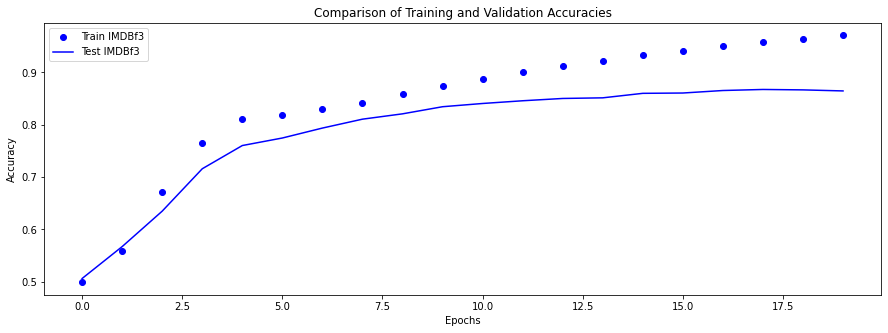

<Figure size 432x288 with 0 Axes>

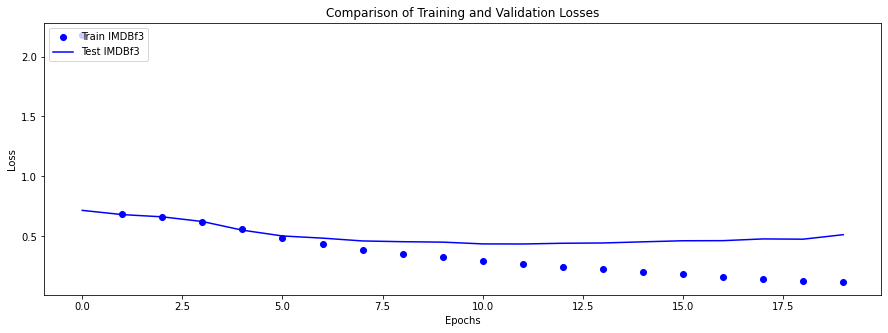

In [7]:
accIMDBf3 = historyIMDBf3.history['acc']
val_accIMDBf3 = historyIMDBf3.history['val_acc']
lossIMDBf3 = historyIMDBf3.history['loss']
val_lossIMDBf3 = historyIMDBf3.history['val_loss']

PlotAccuracyComparison(accIMDBf3, val_accIMDBf3, lab = 'IMDBf3')
PlotLossComparison(lossIMDBf3, val_lossIMDBf3, lab = 'IMDBf3')

In [8]:
modelIMDBf5 = Sequential()
modelIMDBf5.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDBf5.add(layers.Conv1D(32, 5, activation='relu'))
modelIMDBf5.add(layers.MaxPooling1D(3))
modelIMDBf5.add(layers.Conv1D(16, 5, activation='relu'))
modelIMDBf5.add(layers.GlobalMaxPooling1D())
modelIMDBf5.add(layers.Dense(4))
modelIMDBf5.add(layers.Dense(1))

modelIMDBf5.summary()

modelIMDBf5.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
historyIMDBf5 = modelIMDBf5.fit(x_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 496, 32)           20512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 165, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 161, 16)           2576      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 4)                

<Figure size 432x288 with 0 Axes>

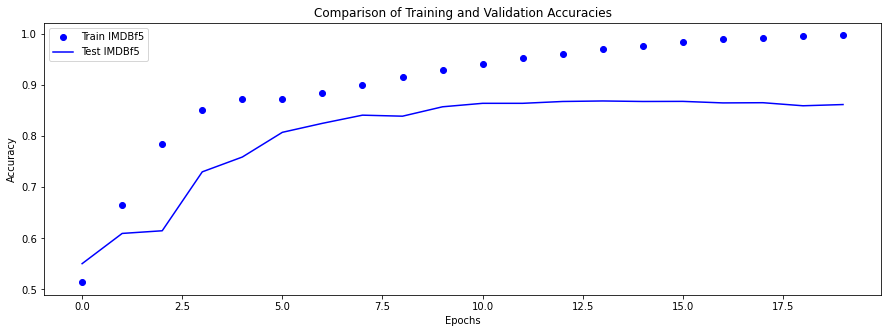

<Figure size 432x288 with 0 Axes>

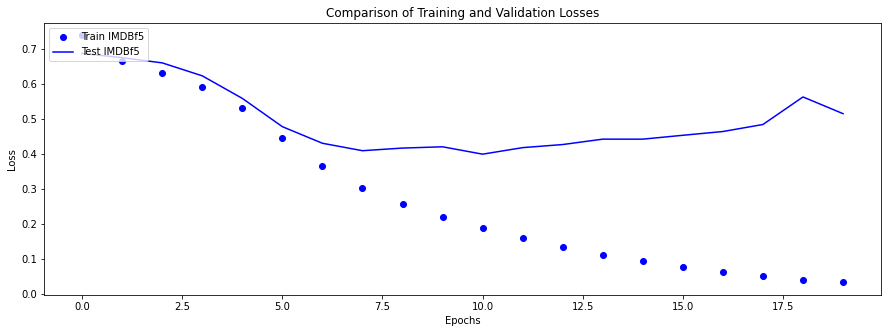

In [9]:
accIMDBf5 = historyIMDBf5.history['acc']
val_accIMDBf5 = historyIMDBf5.history['val_acc']
lossIMDBf5 = historyIMDBf5.history['loss']
val_lossIMDBf5 = historyIMDBf5.history['val_loss']

PlotAccuracyComparison(accIMDBf5, val_accIMDBf5, lab = 'IMDBf5')
PlotLossComparison(lossIMDBf5, val_lossIMDBf5, lab = 'IMDBf5')

In [10]:
modelIMDBf7 = Sequential()
modelIMDBf7.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDBf7.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDBf7.add(layers.MaxPooling1D(3))
modelIMDBf7.add(layers.Conv1D(16, 7, activation='relu'))
modelIMDBf7.add(layers.GlobalMaxPooling1D())
modelIMDBf7.add(layers.Dense(4))
modelIMDBf7.add(layers.Dense(1))

modelIMDBf7.summary()

modelIMDBf7.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
historyIMDBf7 = modelIMDBf7.fit(x_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_4 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 164, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 158, 16)           3600      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 4)                

<Figure size 432x288 with 0 Axes>

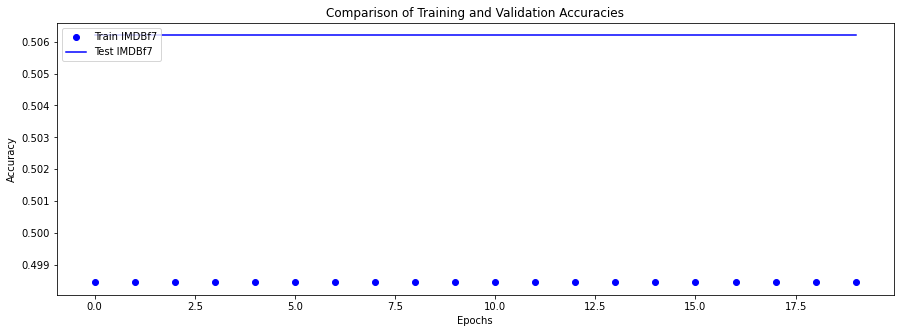

<Figure size 432x288 with 0 Axes>

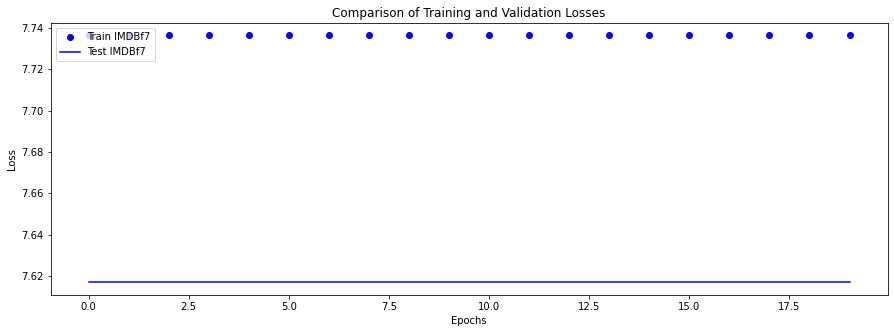

In [11]:
accIMDBf7 = historyIMDBf7.history['acc']
val_accIMDBf7 = historyIMDBf7.history['val_acc']
lossIMDBf7 = historyIMDBf7.history['loss']
val_lossIMDBf7 = historyIMDBf7.history['val_loss']

PlotAccuracyComparison(accIMDBf7, val_accIMDBf7, lab = 'IMDBf7')
PlotLossComparison(lossIMDBf7, val_lossIMDBf7, lab = 'IMDBf7')

In [12]:
modelIMDBf9 = Sequential()
modelIMDBf9.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDBf9.add(layers.Conv1D(32, 9, activation='relu'))
modelIMDBf9.add(layers.MaxPooling1D(3))
modelIMDBf9.add(layers.Conv1D(16, 9, activation='relu'))
modelIMDBf9.add(layers.GlobalMaxPooling1D())
modelIMDBf9.add(layers.Dense(4))
modelIMDBf9.add(layers.Dense(1))

modelIMDBf9.summary()

modelIMDBf9.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
historyIMDBf9 = modelIMDBf9.fit(x_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_6 (Conv1D)           (None, 492, 32)           36896     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 164, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 156, 16)           4624      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 4)                

<Figure size 432x288 with 0 Axes>

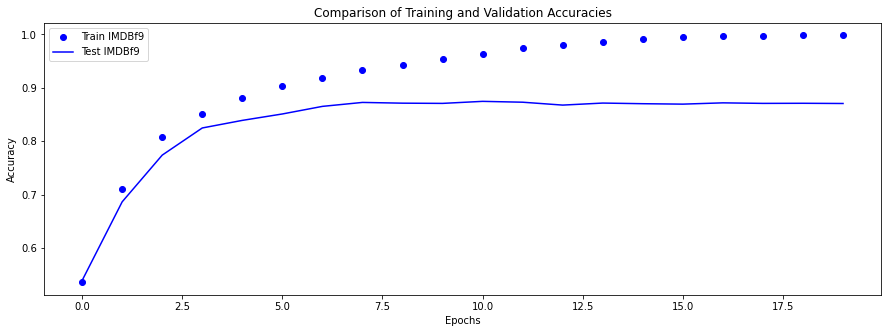

<Figure size 432x288 with 0 Axes>

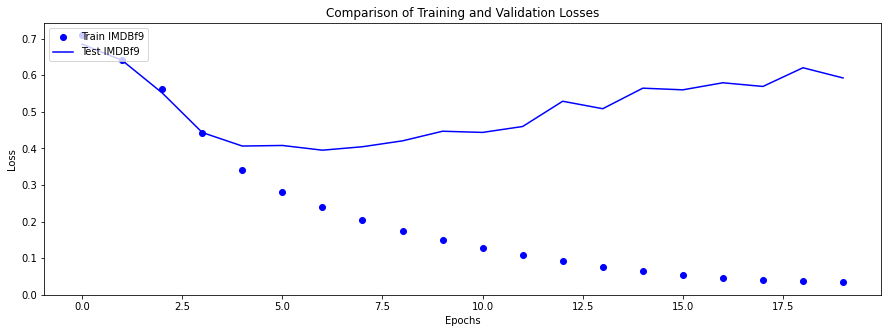

In [13]:
accIMDBf9 = historyIMDBf9.history['acc']
val_accIMDBf9 = historyIMDBf9.history['val_acc']
lossIMDBf9 = historyIMDBf9.history['loss']
val_lossIMDBf9 = historyIMDBf9.history['val_loss']

PlotAccuracyComparison(accIMDBf9, val_accIMDBf9, lab = 'IMDBf9')
PlotLossComparison(lossIMDBf9, val_lossIMDBf9, lab = 'IMDBf9')

As presented above, we achieved results very quickly in comparison to GRU and LSTM networks we will work with next. As we will see later, this is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task. However, we would like to achieve better performance than achieved using only 1D convnets.

# Recurrent Neural Networks

__Recurrent Neural Networks (RNNs)__ have a kind of __process memory__ that was unavailable in convnets where each input shown to them was processed independently, with no state kept in between subsequent inputs. With convnets, in order to process a sequence or a temporal series of data ponts, you have to show the entire sequence (or parts of the sequence using a window) to the convnet at once, simply turning it into a single data point in a multidimensional space. For instance, when we worked with the IMDB dataset, an entire move review was transformed into a single large vector and processes in one go. Such networks are called __feedforward networks__.

__Recurrent Neural Networks (RNNs)__ adopt the same principle, albeit they process sequences by iterating through the sequence elements and maintaining a state containing information relative to what i thas seen so far. In effect, an RNN is a neural network type with an internal loop:

![recurrent neural network](http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/images/RNN.png)

The state of the RNN is reset (initialized) between processing of each two independent sequences (e.g. two different IMDB reviews), so one sequence is still a single data point (input to the RNN). The difference is that now this data point is no longer processed in a single step, but the network internally loops over sequence elements and takes into account all previous states produced by the previous elements in the currently processed sequence when calculating the state for the current sequence element. Each sequence element may be defined by a vector of input data, so when we unfold time, we can treat RNNs as feedforward neural networks with different inputs added to subsequent deep layers which share the same weights:

![unfolded recurrent neural network](http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/images/unfoldedRNN.png)

Let's define a few plotting functions and next, create the first RNN for the IMDB dataset.

In [15]:
import tensorflow as tf
import keras

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

TensorFlow version: 2.10.0
Keras version: 2.10.0


## Definition of plotting functions

First, let's define plotting functions that will be used to chart the plots of the achieved results:

In [14]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

def plt_inline():
    #rc = plt.rcParams.copy()
    %matplotlib inline
    #plt.rcParams.update(rc)

def PlotAccuracyComparison(acc, val_acc, lab = ''):
    plt.clf()   # clear figure
    plt.figure(figsize=(20,5))
    plt_inline()
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = ''):
    plt.clf()   # clear figure
    plt.figure(figsize=(20,5))
    plt_inline()
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()
    
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    plt.figure(figsize=(20,5))
    plt_inline()
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()
    
def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    plt.figure(figsize=(20,5))
    plt_inline()
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

## Simple Numpy Implementation of a Recurrent Neural Network

Before using Keras library, let's implement a simple RNN using the Numpy library and look at how this kind of neural networks works and processes inputs and outputs according to the previous figures. Here, we will just work on random input data, random weights (W and U), biases and evaluate the RNN in 10 subsequent time steps:

In [15]:
import numpy as np

timesteps = 10
input_features = 4
output_features = 8

inputs = np.random.random((timesteps, input_features)) / 10
print("inputs:", inputs)

state_t = np.zeros((output_features,))
print("state_t:", state_t)

W = np.random.random((output_features, input_features)) / 10
print("W:", W)
U = np.random.random((output_features, output_features)) / 10
print("U:", U)
b = np.random.random((output_features,)) / 10
print("b:", b)

successive_outputs = []
for input_t in inputs:
    # The internal state is calculated on the basis of the current input as well as the previous state in time t-1
    state_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # In this simple RNN, the output of the t step is equal to the calculated internal state in time t
    output_t = state_t
    print("output in time t", output_t)
    # Append the calculated output to the output sequence
    successive_outputs.append(output_t)

final_output_sequence = np.concatenate(successive_outputs, axis=0)
print (final_output_sequence)

inputs: [[0.02088021 0.08218429 0.01675776 0.04689678]
 [0.0690648  0.02961003 0.05088102 0.06093652]
 [0.08135665 0.08227455 0.03775941 0.02756107]
 [0.01004108 0.04862368 0.04649283 0.05374283]
 [0.03331293 0.02749962 0.0630258  0.04920999]
 [0.0480735  0.02245504 0.0669092  0.05815002]
 [0.03128382 0.05086593 0.09444599 0.02130207]
 [0.06905957 0.07253404 0.09200537 0.03350681]
 [0.03771688 0.09109774 0.04973695 0.04218347]
 [0.00322019 0.03975995 0.08447245 0.06643408]]
state_t: [0. 0. 0. 0. 0. 0. 0. 0.]
W: [[0.06664572 0.02610355 0.09285103 0.0962159 ]
 [0.01288973 0.07732484 0.06070177 0.01277351]
 [0.07089149 0.0503953  0.01350608 0.03567943]
 [0.00801079 0.06638621 0.02876512 0.04666859]
 [0.08235176 0.01887041 0.02470625 0.06820257]
 [0.05721891 0.02396058 0.07979609 0.00578174]
 [0.08539134 0.05050854 0.03777337 0.00511766]
 [0.06726769 0.08856075 0.09598308 0.06768754]]
U: [[0.00705234 0.04697534 0.08463434 0.05081297 0.09853508 0.02562572
  0.06369934 0.07579535]
 [0.069600

## Recurrent layers in Keras

The process we just implemented in Numpy corresponds to an actual Keras `SimpleRNN` layer, but it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes:
* it can return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`), or
* it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

These two modes are controlled by the `return_sequences` constructor argument. Let's take a look at two examples demonstrating these two options:

In [16]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
# Turn positive integers (indexes) into dense vectors of the fixed and defined size.
model.add(Embedding(10000, 32))  # This layer can only be used as the first layer in a model
model.add(SimpleRNN(32))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [17]:
model = Sequential()
model.add(Embedding(10000, 32)) # https://keras.io/api/layers/core_layers/embedding/ 
model.add(SimpleRNN(32, return_sequences=True))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [20]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last output.

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## Set up the model directory for saving the trained models

In [21]:
import os

# The path to store trained models
models_dir = 'C:/ml/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

## Implementation of RNN to the IMDB movie review classification problem

Now let's try to use such a recurrent model on the IMDB movie review classification problem, where the reviews will be assigned to one of two classes as being positive or negative. So, a single output is necessary. First, let's preprocess the data:

In [19]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 1000  # cut texts after this number of words (among top max_features most common words)
batch_size = 64 #32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time) to the same length.')
input_train = pad_sequences(input_train, maxlen=maxlen) # Pads sequences to the same length (truncates or pads with zeros).
input_test = pad_sequences(input_test, maxlen=maxlen) # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time) to the same length.
input_train shape: (25000, 1000)
input_test shape: (25000, 1000)


Let's train a simple recurrent network containing an `Embedding` layer and a `SimpleRNN` layer on such prepared training data:

In [ ]:
from keras.layers import Dense, Dropout

epochs = 50
batch_size = 256

modelIMDBSimpleRNN = Sequential()
modelIMDBSimpleRNN.add(Embedding(max_features, 64)) #32
modelIMDBSimpleRNN.add(SimpleRNN(64)) #32
#modelIMDBSimpleRNN.add(Dropout(0.125)) #+
modelIMDBSimpleRNN.add(Dense(8, activation='relu')) #added (81%/20ep)
modelIMDBSimpleRNN.add(Dense(1, activation='sigmoid'))

modelIMDBSimpleRNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
historyIMDBSimpleRNN = modelIMDBSimpleRNN.fit(input_train, y_train,
                                              epochs = epochs,
                                              batch_size = batch_size,
                                              validation_split = 0.2)

modelIMDBSimpleRNN.save(models_dir + 'IMDB_SimpleRNN.h5')

Epoch 1/50
14/79 [====>.........................] - ETA: 2:51 - loss: 0.6967 - acc: 0.5103

Let's display the training and validation loss and accuracy:

In [ ]:
accIMDBSimpleRNN = historyIMDBSimpleRNN.history['acc']
val_accIMDBSimpleRNN = historyIMDBSimpleRNN.history['val_acc']
lossIMDBSimpleRNN = historyIMDBSimpleRNN.history['loss']
val_lossIMDBSimpleRNN = historyIMDBSimpleRNN.history['val_loss']

PlotAccuracyComparison(accIMDBSimpleRNN, val_accIMDBSimpleRNN, lab = 'IMDB-SimpleRNN')
PlotLossComparison(lossIMDBSimpleRNN, val_lossIMDBSimpleRNN, lab = 'IMDB-SimpleRNN')

Previously, using a simple `Dense` layer network, we got about 86% validation accuracy to this dataset, so got better results to those achieved now using a simple `SimpleRNN` layer network. Unfortunately, our small recurrent network does not perform better compared to this baseline. Moreover, it overfits quickly after the training is started. The part of the problem is that our inputs only consider the first 1000 words rather the full sequences - hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` is not very good at processing long sequences, like text, so we should use other types of recurrent layers, which perform much better. Let's take a look at some more advanced layers.

## A network using an LSTM layer to the IMDB movie review classification problem

Now let's set up a model using an `LSTM` layer, which usually works better with long sequences that `SimpleRNN`, and train it on the IMDB data. LSTM stands for Long-Short Term Memory and is a kind of recurrent neural networks. Let's create a network using `LSTM`, similar to the previous one with `SimpleRNN`. We only specify the output dimensionality of the `LSTM` layer, and leave all other arguments to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you having to spend time tuning parameters by hand. However, with growing experience, you can try to change defauls!

In [25]:
from keras.layers import LSTM

modelIMDBLSTM = Sequential()
modelIMDBLSTM.add(Embedding(max_features, 64)) #32
modelIMDBLSTM.add(LSTM(64)) #32  # https://keras.io/api/layers/recurrent_layers/lstm/
#modelIMDBLSTM.add(Dropout(0.125)) #+
modelIMDBLSTM.add(Dense(8, activation='relu')) #added (87%/20ep)
modelIMDBLSTM.add(Dense(1, activation='sigmoid'))

modelIMDBLSTM.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
historyIMDBLSTM = modelIMDBLSTM.fit(input_train, y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_split=0.2)

modelIMDBLSTM.save(models_dir + 'IMDB_LSTM.h5')

Epoch 1/50
79/79 [==============================] - 13s 106ms/step - loss: 0.5958 - acc: 0.7142 - val_loss: 0.4474 - val_acc: 0.7994
Epoch 2/50
79/79 [==============================] - 8s 101ms/step - loss: 0.3694 - acc: 0.8557 - val_loss: 0.4260 - val_acc: 0.8156
Epoch 3/50
79/79 [==============================] - 8s 98ms/step - loss: 0.2838 - acc: 0.8906 - val_loss: 0.3878 - val_acc: 0.8268
Epoch 4/50
79/79 [==============================] - 8s 105ms/step - loss: 0.2465 - acc: 0.9039 - val_loss: 0.2988 - val_acc: 0.8898
Epoch 5/50
79/79 [==============================] - 8s 104ms/step - loss: 0.2073 - acc: 0.9245 - val_loss: 0.3119 - val_acc: 0.8912
Epoch 6/50
79/79 [==============================] - 8s 103ms/step - loss: 0.1919 - acc: 0.9298 - val_loss: 0.3341 - val_acc: 0.8854
Epoch 7/50
79/79 [==============================] - 8s 101ms/step - loss: 0.1632 - acc: 0.9407 - val_loss: 0.6102 - val_acc: 0.8126
Epoch 8/50
79/79 [==============================] - 8s 106ms/step - loss: 0.

As we can see, the training time of an `LSTM` layer is a few times longer than for a `SimpleRNN` layer, but the results achieved for the model encompassing an `LSTM` layer is better and more stable than the model using a `SimpleRNN` layer. The model based on an `LSTM` layer does not overfit so much as the previous one. The LSTM-based model also achieved better final accuracy than the base-line model using only `Dense` layers.

In [26]:
accIMDBLSTM = historyIMDBLSTM.history['acc']
val_accIMDBLSTM = historyIMDBLSTM.history['val_acc']
lossIMDBLSTM = historyIMDBLSTM.history['loss']
val_lossIMDBLSTM = historyIMDBLSTM.history['val_loss']

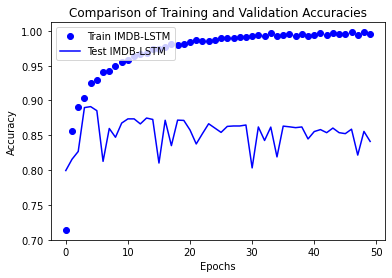

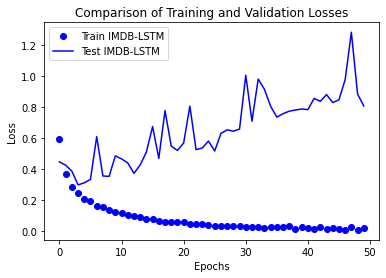

In [27]:
PlotAccuracyComparison(accIMDBLSTM, val_accIMDBLSTM, lab = 'IMDB-LSTM')
PlotLossComparison(lossIMDBLSTM, val_lossIMDBLSTM, lab = 'IMDB-LSTM')

Now, let's compare these two models: the `SimpleRNN` and `LSTM` models:

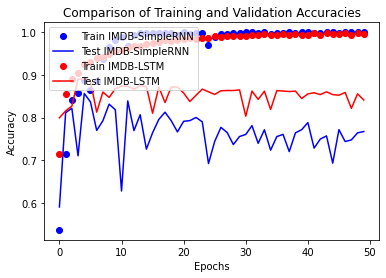

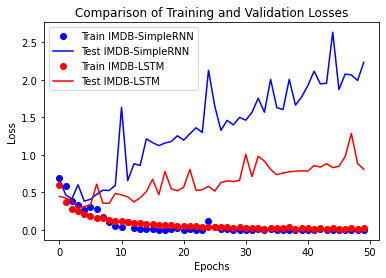

In [28]:
PlotTwoAccuracyComparison(accIMDBSimpleRNN[:epochs], val_accIMDBSimpleRNN[:epochs], accIMDBLSTM[:epochs], val_accIMDBLSTM[:epochs], lab1 = 'IMDB-SimpleRNN', lab2 = 'IMDB-LSTM')
PlotTwoLossComparison(lossIMDBSimpleRNN[:epochs], val_lossIMDBSimpleRNN[:epochs], lossIMDBLSTM[:epochs], val_lossIMDBLSTM[:epochs], lab1 = 'IMDB-SimpleRNN', lab2 = 'IMDB-LSTM')

The comparisons have shown that the LSTM-based network is training longer but more stable and with smaller variance (overfits less).

We use LSTM and GRU layers to struggle for a better solution when training long sequences. Let's try to use a GRU layer instead of an LSTM layer.

In [29]:
from keras.layers import GRU

modelIMDBGRU = Sequential()
modelIMDBGRU.add(Embedding(max_features, 64))#32
modelIMDBGRU.add(GRU(64))#32  # https://keras.io/api/layers/recurrent_layers/gru/
#modelIMDBGRU.add(Dropout(0.125)) #+
modelIMDBGRU.add(Dense(8, activation='relu')) #added (85%/20ep)
modelIMDBGRU.add(Dense(1, activation='sigmoid'))

modelIMDBGRU.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])
historyIMDBGRU = modelIMDBGRU.fit(input_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_split=0.2)

modelIMDBGRU.save(models_dir + 'IMDB_GRU.h5')

Epoch 1/50
79/79 [==============================] - 10s 94ms/step - loss: 0.6380 - acc: 0.6795 - val_loss: 0.5297 - val_acc: 0.7270
Epoch 2/50
79/79 [==============================] - 7s 86ms/step - loss: 0.3947 - acc: 0.8278 - val_loss: 0.3948 - val_acc: 0.8230
Epoch 3/50
79/79 [==============================] - 7s 88ms/step - loss: 0.2971 - acc: 0.8782 - val_loss: 0.5605 - val_acc: 0.7992
Epoch 4/50
79/79 [==============================] - 7s 86ms/step - loss: 0.2609 - acc: 0.8966 - val_loss: 0.3565 - val_acc: 0.8444
Epoch 5/50
79/79 [==============================] - 7s 88ms/step - loss: 0.2291 - acc: 0.9092 - val_loss: 0.3374 - val_acc: 0.8650
Epoch 6/50
79/79 [==============================] - 7s 87ms/step - loss: 0.2002 - acc: 0.9232 - val_loss: 0.3656 - val_acc: 0.8408
Epoch 7/50
79/79 [==============================] - 7s 90ms/step - loss: 0.1855 - acc: 0.9306 - val_loss: 0.3614 - val_acc: 0.8484
Epoch 8/50
79/79 [==============================] - 7s 90ms/step - loss: 0.1652 - 

In [30]:
accIMDBGRU = historyIMDBGRU.history['acc']
val_accIMDBGRU = historyIMDBGRU.history['val_acc']
lossIMDBGRU = historyIMDBGRU.history['loss']
val_lossIMDBGRU = historyIMDBGRU.history['val_loss']

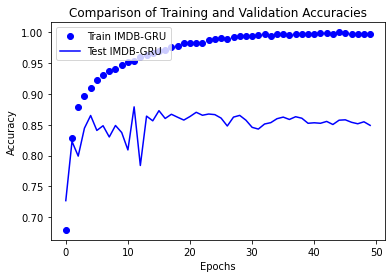

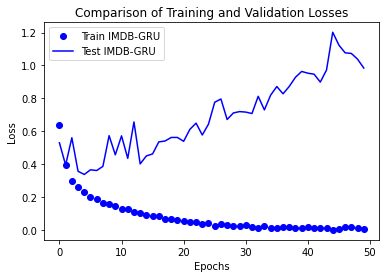

In [31]:
PlotAccuracyComparison(accIMDBGRU, val_accIMDBGRU, lab = 'IMDB-GRU')
PlotLossComparison(lossIMDBGRU, val_lossIMDBGRU, lab = 'IMDB-GRU')

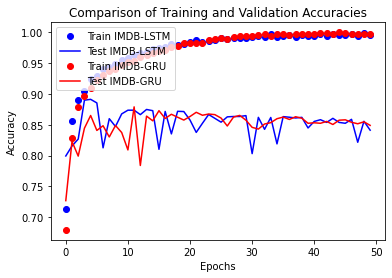

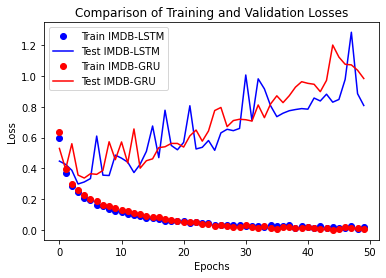

In [32]:
PlotTwoAccuracyComparison(accIMDBLSTM[:epochs], val_accIMDBLSTM[:epochs], accIMDBGRU[:epochs], val_accIMDBGRU[:epochs], lab1 = 'IMDB-LSTM', lab2 = 'IMDB-GRU')
PlotTwoLossComparison(lossIMDBLSTM[:epochs], val_lossIMDBLSTM[:epochs], lossIMDBGRU[:epochs], val_lossIMDBGRU[:epochs], lab1 = 'IMDB-LSTM', lab2 = 'IMDB-GRU')

The achieved results for the GRU-based network are similar to those achieved for the LSTM-based network.

# Advanced techniques for improving the performance and generalization of RNN

Let's look at three advanced techniques for improving the performance and generalization power of recurrent neural networks. These concepts will be demonstrated on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We will cover the following techniques:

* __Recurrent dropout__, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* __Stacking recurrent layers__, to increase the representational power of the network (at the cost of higher computational loads).
* __Bidirectional recurrent layers__, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence data can be found in many other problems than just natural language processing (NLP). For a change, we will be playing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (air temperature, relative humidity, air pressure, precipitation, wind velocity and direction, global radiation, CO2-concentration, etc.) are recorded every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2015-2021. We will use it for learning to work with numerical timeseries and to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

First, we must download the dataset from https://www.bgc-jena.mpg.de/wetter/weather_data.html, unzip, consolidate, and upload data to our notebook:

In [33]:
import os

# You can download sample data from = 'http://home.agh.edu.pl/~horzyk/ml/data/weather/mpi_roof_2015-2021.zip'
data_dir = 'C:/ml/data/weather' # Unzip data and change this directory to yours
fname = os.path.join(data_dir, 'mpi_roof_2015-2021.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(lines[1:3])

print("Data attribute names for this dataset are:")
print(header)
print("Number of training examples: ", len(lines))

['01.01.2015 00:20:00,1007.18,2.1,274.7,1.93,98.8,7.11,7.03,0.09,4.35,6.98,1271.28,0.65,1.16,129.3,0,0,0,0,0,14.26,434.2', '01.01.2015 00:30:00,1007.17,2.08,274.67,1.91,98.8,7.1,7.01,0.09,4.34,6.96,1271.4,0.46,1.64,134.1,0,0,0,0,0,14.27,435.8']
Data attribute names for this dataset are:
['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m˛)', 'PAR (µmol/m˛/s)', 'max. PAR (µmol/m˛/s)', 'Tlog (degC)', 'CO2 (ppm)']
Number of training examples:  332694


Let's convert all of these lines of data into a Numpy array:

In [34]:
import numpy as np

dim = len(header) - 1
float_data = np.zeros((len(lines), dim))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    if len(values) == dim:
        float_data[i, :] = values

Here is the plot of temperature in degrees Celsius over time:

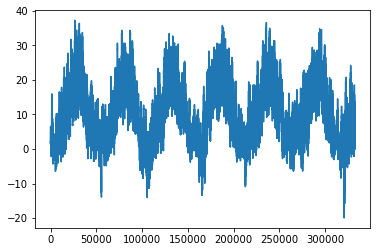

In [35]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first thirty days of temperature data (since the data is recorded every ten minutes, we get 144 data points per day):

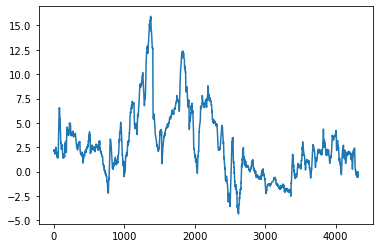

In [36]:
days = 30
plt.plot(range(144*days), temp[:144*days])
plt.show()

On this plot, you can see daily periodicity. We can also note that this thirty-days period must be coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Let's find out, whether this timeseries is predictable at a daily scale?

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [37]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and `targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [38]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [39]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline

Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for which there is no known solution yet. A classic example is that of unbalanced classification tasks, where some classes can be much more common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). Mean Absolute Error is simply equal to:

`np.mean(np.abs(preds - targets))`

Here's our evaluation loop:

In [40]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    global mae_error
    mae_error = np.mean(batch_maes)
    print(mae_error)
    
evaluate_naive_method()

0.3403956845000855


In [41]:
print(temp[:])
temperature_std = np.std(temp[:])
print(temperature_std)

[-1.01672015 -1.02273289 -1.02513799 ... -0.27955804 -0.30120391
 -1.27526804]
0.9809440029594403


In [42]:
avgerror = mae_error * temperature_std
print(avgerror)

0.33390910534363255


It yields a MAE of 0.33. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this number is not immediately interpretable. It translates to an average absolute error of `0.34 * temperature_std` degrees Celsius, i.e. 0.33˚C. That's a fairly large average absolute error - now the game is to leverage our knowledge of deep learning to do better. 

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches and try simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [43]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop

epochs = 50

modelTEMPDense = Sequential()
modelTEMPDense.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
#modelTEMPDense.add(layers.Dropout(0.125)) #+
modelTEMPDense.add(layers.Dense(64, activation='relu')) #32
modelTEMPDense.add(layers.Dense(1))

modelTEMPDense.compile(optimizer=RMSprop(), loss='mae')
#historyTEMPDense = modelTEMPDense.fit_generator(train_gen,
historyTEMPDense = modelTEMPDense.fit(train_gen,
                                                steps_per_epoch=500,
                                                epochs=epochs,
                                                validation_data=val_gen,
                                                validation_steps=val_steps)

modelTEMPDense.save(models_dir + 'TEMP-Dense.h5')

Epoch 1/50
500/500 [==============================] - 13s 26ms/step - loss: 1.4954 - val_loss: 0.7898
Epoch 2/50
500/500 [==============================] - 13s 26ms/step - loss: 0.3842 - val_loss: 0.3925
Epoch 3/50
500/500 [==============================] - 13s 26ms/step - loss: 0.3195 - val_loss: 0.5065
Epoch 4/50
500/500 [==============================] - 13s 25ms/step - loss: 0.3081 - val_loss: 0.3764
Epoch 5/50
500/500 [==============================] - 12s 23ms/step - loss: 0.2992 - val_loss: 0.4142
Epoch 6/50
500/500 [==============================] - 11s 23ms/step - loss: 0.2991 - val_loss: 0.4020
Epoch 7/50
500/500 [==============================] - 12s 24ms/step - loss: 0.3013 - val_loss: 0.4111
Epoch 8/50
500/500 [==============================] - 14s 28ms/step - loss: 0.3014 - val_loss: 0.4148
Epoch 9/50
500/500 [==============================] - 13s 26ms/step - loss: 0.3042 - val_loss: 0.4346
Epoch 10/50
500/500 [==============================] - 13s 25ms/step - loss: 0.298

Let's display the accuracy and loss curves for validation and training:

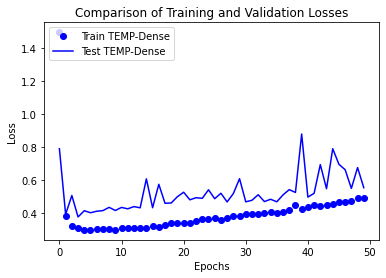

In [44]:
lossTEMPDense = historyTEMPDense.history['loss']
val_lossTEMPDense = historyTEMPDense.history['val_loss']

PlotLossComparison(lossTEMPDense, val_lossTEMPDense, lab = 'TEMP-Dense')


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline

Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let's look at our data as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model - it should be the perfect fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

We will use the `GRU` layer (which stands for __Gated Recurrent Unit__), developed by Cho et al. in 2014. `GRU` layers work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run, albeit they may not have quite as much representational power as LSTM layers. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [45]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop

modelTEMPGRU = Sequential()
modelTEMPGRU.add(layers.GRU(64, input_shape=(None, float_data.shape[-1]))) #32
modelTEMPGRU.add(layers.Dropout(0.125)) #+
modelTEMPGRU.add(layers.Dense(8, activation='relu')) #added (33%/20ep)
modelTEMPGRU.add(layers.Dense(1))

modelTEMPGRU.compile(optimizer=RMSprop(), loss='mae')
#historyTEMPGRU = modelTEMPGRU.fit_generator(train_gen,
historyTEMPGRU = modelTEMPGRU.fit(train_gen,
                                            steps_per_epoch=500,
                                            epochs=epochs,
                                            validation_data=val_gen,
                                            validation_steps=val_steps)

modelTEMPGRU.save(models_dir + 'TEMP-GRU.h5')

Epoch 1/50
500/500 [==============================] - 18s 32ms/step - loss: 0.3113 - val_loss: 0.3039
Epoch 2/50
500/500 [==============================] - 16s 31ms/step - loss: 0.2869 - val_loss: 0.3048
Epoch 3/50
500/500 [==============================] - 16s 31ms/step - loss: 0.2763 - val_loss: 0.2902
Epoch 4/50
500/500 [==============================] - 16s 32ms/step - loss: 0.2680 - val_loss: 0.2935
Epoch 5/50
500/500 [==============================] - 16s 32ms/step - loss: 0.2609 - val_loss: 0.2926
Epoch 6/50
500/500 [==============================] - 16s 32ms/step - loss: 0.2559 - val_loss: 0.2979
Epoch 7/50
500/500 [==============================] - 16s 32ms/step - loss: 0.2489 - val_loss: 0.3006
Epoch 8/50
500/500 [==============================] - 16s 31ms/step - loss: 0.2415 - val_loss: 0.3031
Epoch 9/50
500/500 [==============================] - 16s 32ms/step - loss: 0.2304 - val_loss: 0.3037
Epoch 10/50
500/500 [==============================] - 17s 33ms/step - loss: 0.219

Let's look at our results:

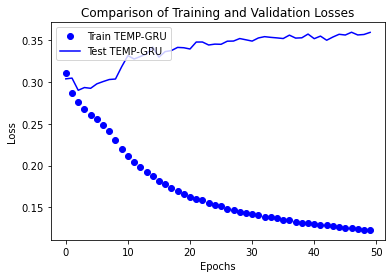

In [46]:
lossTEMPGRU = historyTEMPGRU.history['loss']
val_lossTEMPGRU = historyTEMPGRU.history['val_loss']

PlotLossComparison(lossTEMPGRU, val_lossTEMPGRU, lab = 'TEMP-GRU')

Here is the comparison of these two models:

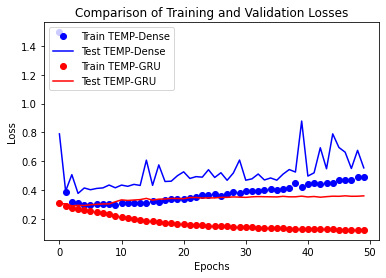

In [47]:
PlotTwoLossComparison(lossTEMPDense[:epochs], val_lossTEMPDense[:epochs], lossTEMPGRU[:epochs], val_lossTEMPGRU[:epochs], lab1 = 'TEMP-Dense', lab2 = 'TEMP-GRU')

In [48]:
avgerror = val_lossTEMPGRU[-1] * temperature_std
print(avgerror)

0.35266973656002437


We see that the GRU model behaves much better than the Dense model! We are also able to beat the common sense baseline, such demonstrating the value of machine learning here, as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.24 translates to a mean absolute error of 0.24˚C after de-normalization in the 10th epoch, next, the training process overfitted, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting

It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging considerably after a few epochs (growing variance of the model). You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let's add them to our GRU layer and see how it impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many epochs.

In [ ]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from keras import regularizers

epochs = 50

modelTEMPDropoutGRU = Sequential()
modelTEMPDropoutGRU.add(layers.GRU(64, dropout=0.05, recurrent_dropout=0.05, 
                                   input_shape=(None, float_data.shape[-1]),
                                   kernel_regularizer=regularizers.l2(0.001))) #32
#modelTEMPDropoutGRU.add(layers.Dropout(0.125)) #+
modelTEMPDropoutGRU.add(layers.Dense(8, activation='relu')) #added (34%/40ep)
modelTEMPDropoutGRU.add(layers.Dense(1))

modelTEMPDropoutGRU.compile(optimizer=RMSprop(), loss='mae')

#historyTEMPDropoutGRU = modelTEMPDropoutGRU.fit_generator(train_gen,
historyTEMPDropoutGRU = modelTEMPDropoutGRU.fit(train_gen,
                                                          steps_per_epoch=500,
                                                          epochs=epochs,
                                                          validation_data=val_gen,
                                                          validation_steps=val_steps)

modelTEMPDropoutGRU.save(models_dir + 'TEMP-DropoutGRU.h5')

Epoch 1/50
500/500 [==============================] - 1187s 2s/step - loss: 0.3201 - val_loss: 0.3189
Epoch 2/50
500/500 [==============================] - 591s 1s/step - loss: 0.2957 - val_loss: 0.3134
Epoch 3/50
500/500 [==============================] - 686s 1s/step - loss: 0.2864 - val_loss: 0.3113
Epoch 4/50
500/500 [==============================] - 606s 1s/step - loss: 0.2782 - val_loss: 0.3045
Epoch 5/50
500/500 [==============================] - 614s 1s/step - loss: 0.2720 - val_loss: 0.3046
Epoch 6/50
500/500 [==============================] - 623s 1s/step - loss: 0.2645 - val_loss: 0.3078
Epoch 7/50
500/500 [==============================] - 628s 1s/step - loss: 0.2563 - val_loss: 0.3257
Epoch 8/50
500/500 [==============================] - 618s 1s/step - loss: 0.2482 - val_loss: 0.3221
Epoch 9/50
500/500 [==============================] - 623s 1s/step - loss: 0.2426 - val_loss: 0.3303
Epoch 10/50
500/500 [==============================] - 618s 1s/step - loss: 0.2359 - val_l

In [ ]:
lossTEMPDropoutGRU = historyTEMPDropoutGRU.history['loss']
val_lossTEMPDropoutGRU = historyTEMPDropoutGRU.history['val_loss']

PlotLossComparison(lossTEMPDropoutGRU, val_lossTEMPDropoutGRU, lab = 'TEMP-DropoutGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPGRU[:epochs], val_lossTEMPGRU[:epochs], lossTEMPDropoutGRU[:epochs], val_lossTEMPDropoutGRU[:epochs], lab1 = 'TEMP-GRU', lab2 = 'TEMP-DropoutGRU')

The validation loss was stabilized but there is still a big variance, so maybe this model should be trained longer because the validation loss is decreasing, as well as overfitting.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of our network. It is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity (underfitting).

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is a stack of seven large LSTM layers - that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep because we need them to feed to the next recurrent layer as an input. This is done by specifying `return_sequences=True`: 

In [ ]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop

modelTEMPDropout2xGRU = Sequential()
modelTEMPDropout2xGRU.add(layers.GRU(64,
                          dropout=0.05,
                          recurrent_dropout=0.05,
                          return_sequences=True,
                          input_shape=(None, float_data.shape[-1]),
                          kernel_regularizer=regularizers.l2(0.001))) #32
modelTEMPDropout2xGRU.add(layers.GRU(32,
                          dropout=0.05,
                          recurrent_dropout=0.05,
                          return_sequences=True,
                          input_shape=(None, float_data.shape[-1]),
                          kernel_regularizer=regularizers.l2(0.001))) #32 added
modelTEMPDropout2xGRU.add(layers.GRU(16,
                                     activation='relu',
                                     dropout=0.05, 
                                     recurrent_dropout=0.05,
                                     kernel_regularizer=regularizers.l2(0.001))) #32
#modelTEMPDropout2xGRU.add(layers.Dropout(0.125)) #+
modelTEMPDropout2xGRU.add(layers.Dense(8, activation='relu')) #added (36%/40ep)
modelTEMPDropout2xGRU.add(layers.Dense(1))

modelTEMPDropout2xGRU.compile(optimizer=RMSprop(), loss='mae')
#historyTEMPDropout2xGRU = modelTEMPDropout2xGRU.fit_generator(train_gen,
historyTEMPDropout2xGRU = modelTEMPDropout2xGRU.fit(train_gen,
                                                              steps_per_epoch=500,
                                                              epochs=epochs,
                                                              validation_data=val_gen,
                                                              validation_steps=val_steps)

modelTEMPDropout2xGRU.save(models_dir + 'TEMP-Dropout2xGRU.h5')

Let's take a look at our results:

In [ ]:
lossTEMPDropout2xGRU = historyTEMPDropout2xGRU.history['loss']
val_lossTEMPDropout2xGRU = historyTEMPDropout2xGRU.history['val_loss']

PlotLossComparison(lossTEMPDropout2xGRU, val_lossTEMPDropout2xGRU, lab = 'TEMP-Dropout2xGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPDropoutGRU[:epochs], val_lossTEMPDropoutGRU[:epochs], lossTEMPDropout2xGRU[:epochs], val_lossTEMPDropout2xGRU[:epochs], lab1 = 'TEMP-DropoutGRU', lab2 = 'TEMP-Dropout2xGRU')

We can see that the addition of an extra recurrent layer combined with dropout improved ours results a lot. Surprisingly, the validation loss is even lower than the training loss, but such a strange effect can be achieved when using a dropout that is implemented only during the training, not when validating. It is just our best result, much below the baseline.

## Using bidirectional RNNs

The last technique that we will introduce in this section is called __bidirectional RNNs__. A bidirectional RNN is a common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing - you could call it the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we used in the first experiment in this section, we get the following results:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
modelTEMPReverseGRU = Sequential()
modelTEMPReverseGRU.add(layers.GRU(64, input_shape=(None, float_data.shape[-1]),
                                  kernel_regularizer=regularizers.l2(0.001))) #32
#modelTEMPReverseGRU.add(layers.Dropout(0.125)) #+
modelTEMPReverseGRU.add(layers.Dense(8, activation='relu')) #added (41%/20ep)
modelTEMPReverseGRU.add(layers.Dense(1))

modelTEMPReverseGRU.compile(optimizer=RMSprop(), loss='mae')
#historyTEMPReverseGRU = modelTEMPReverseGRU.fit_generator(train_gen_reverse,
historyTEMPReverseGRU = modelTEMPReverseGRU.fit(train_gen_reverse,
                                                          steps_per_epoch=500,
                                                          epochs=epochs,
                                                          validation_data=val_gen_reverse,
                                                          validation_steps=val_steps)

modelTEMPReverseGRU.save(models_dir + 'TEMP-ReverseGRU.h5')

In [ ]:
lossTEMPReverseGRU = historyTEMPReverseGRU.history['loss']
val_lossTEMPReverseGRU = historyTEMPReverseGRU.history['val_loss']

PlotLossComparison(lossTEMPReverseGRU, val_lossTEMPReverseGRU, lab = 'TEMP-ReverseGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPGRU[:epochs], val_lossTEMPGRU[:epochs], lossTEMPReverseGRU[:epochs], val_lossTEMPReverseGRU[:epochs], lab1 = 'TEMP-GRU', lab2 = 'TEMP-ReverseGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPDropoutGRU[:epochs], val_lossTEMPDropoutGRU[:epochs], lossTEMPReverseGRU[:epochs], val_lossTEMPReverseGRU[:epochs], lab1 = 'TEMP-DropoutGRU', lab2 = 'TEMP-ReverseGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPDropout2xGRU[:epochs], val_lossTEMPDropout2xGRU[:epochs], lossTEMPReverseGRU[:epochs], val_lossTEMPReverseGRU[:epochs], lab1 = 'TEMP-Dropout2xGRU', lab2 = 'TEMP-ReverseGRU')

So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus, the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's try the same trick on the LSTM to the IMDB data:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

modelIMDBReverseLSTM = Sequential()
modelIMDBReverseLSTM.add(layers.Embedding(max_features, 128))
modelIMDBReverseLSTM.add(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001))) #32
#modelIMDBReverseLSTM.add(layers.Dropout(0.125)) #+
modelIMDBReverseLSTM.add(layers.Dense(8, activation='relu')) #added (83%/20ep)
modelIMDBReverseLSTM.add(layers.Dense(1, activation='sigmoid'))

modelIMDBReverseLSTM.compile(optimizer='rmsprop',
                             loss='binary_crossentropy',
                             metrics=['acc'])
historyIMDBReverseLSTM = modelIMDBReverseLSTM.fit(x_train, y_train,
                                                  epochs=epochs,
                                                  batch_size=128,
                                                  validation_split=0.2)

modelIMDBReverseLSTM.save(models_dir + 'IMDB-ReverseLSTM.h5')

Let's see the results and their comparisons:

In [ ]:
lossIMDBReverseLSTM = historyIMDBReverseLSTM.history['loss']
val_lossIMDBReverseLSTM = historyIMDBReverseLSTM.history['val_loss']

PlotLossComparison(lossIMDBReverseLSTM, val_lossIMDBReverseLSTM, lab = 'LSTM')

In [ ]:
PlotTwoLossComparison(lossIMDBLSTM[:epochs], val_lossIMDBLSTM[:epochs], lossIMDBReverseLSTM[:epochs], val_lossIMDBReverseLSTM[:epochs], lab1 = 'IMDB-LSTM', lab2 = 'IMDB-ReverseLSTM')


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained on reversed sequences will learn different representations than one trained on the original sequences (in natural order), in much the same way that you would have quite different mental models if time flowed backwards in the real world - if you lived a life where you died on your first day and you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can allow to boost performance on a task. This is the intuition behind __ensembling__, a concept that we will introduce soon.

A __bidirectional RNN__ exploits this idea to improve upon the performance of a chronological-order RNN: it looks at its inputs sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/images/MergingOfRNNs.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
modelIMDBBidirectLSTM = Sequential()
modelIMDBBidirectLSTM.add(layers.Embedding(max_features, 64))#64
modelIMDBBidirectLSTM.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001)),
                                              input_shape=(None, float_data.shape[-1])))
#modelIMDBBidirectLSTM.add(layers.Dropout(0.125)) #+
modelIMDBBidirectLSTM.add(layers.Dense(8, activation='relu')) #added (87%/20ep)
modelIMDBBidirectLSTM.add(layers.Dense(1, activation='sigmoid'))

modelIMDBBidirectLSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
historyIMDBBidirectLSTM = modelIMDBBidirectLSTM.fit(x_train, y_train, epochs=epochs, batch_size=128, validation_split=0.2)

modelIMDBBidirectLSTM.save(models_dir + 'IMDB-BidirectLSTM.h5')

In [ ]:
lossIMDBBidirectLSTM = historyIMDBBidirectLSTM.history['loss']
val_lossIMDBBidirectLSTM = historyIMDBBidirectLSTM.history['val_loss']

PlotLossComparison(lossIMDBBidirectLSTM, val_lossIMDBBidirectLSTM, lab = 'BidirectLSTM')

In [ ]:
PlotTwoLossComparison(lossIMDBLSTM[:epochs], val_lossIMDBLSTM[:epochs], lossIMDBBidirectLSTM[:epochs], val_lossIMDBBidirectLSTM[:epochs], lab1 = 'IMDB-LSTM', lab2 = 'IMDB-BidirectLSTM')

In [ ]:
PlotTwoLossComparison(lossIMDBReverseLSTM[:epochs], val_lossIMDBReverseLSTM[:epochs], lossIMDBBidirectLSTM[:epochs], val_lossIMDBBidirectLSTM[:epochs], lab1 = 'IMDB-ReverseLSTM', lab2 = 'IMDB-BidirectLSTM')

It performs similarly to the regular LSTM we tried previously, going above ~88% validation accuracy. It also seems to overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

In [ ]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop

modelTEMPBidirectGRU = Sequential()
modelTEMPBidirectGRU.add(layers.Bidirectional(layers.GRU(64, kernel_regularizer=regularizers.l2(0.001)),
                                              input_shape=(None, float_data.shape[-1])))
#modelTEMPBidirectGRU.add(layers.Dropout(0.125)) #+
modelTEMPBidirectGRU.add(layers.Dense(8, activation='relu')) #added (36%/40ep)
modelTEMPBidirectGRU.add(layers.Dense(1))

modelTEMPBidirectGRU.compile(optimizer=RMSprop(), loss='mae')
#historyTEMPBidirectGRU = modelTEMPBidirectGRU.fit_generator(train_gen,
historyTEMPBidirectGRU = modelTEMPBidirectGRU.fit(train_gen,
                                                            steps_per_epoch=500,
                                                            epochs=epochs,
                                                            validation_data=val_gen,
                                                            validation_steps=val_steps)

modelTEMPBidirectGRU.save(models_dir + 'TEMP-BidirectGRU.h5')

In [ ]:
lossTEMPBidirectGRU = historyTEMPBidirectGRU.history['loss']
val_lossTEMPBidirectGRU = historyTEMPBidirectGRU.history['val_loss']

PlotLossComparison(lossTEMPBidirectGRU, val_lossTEMPBidirectGRU, lab = 'TEMP-BidirectGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPGRU[:epochs], val_lossTEMPGRU[:epochs], lossTEMPBidirectGRU[:epochs], val_lossTEMPBidirectGRU[:epochs], lab1 = 'TEMP-GRU', lab2 = 'TEMP-BidirectGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPDropoutGRU[:epochs], val_lossTEMPDropoutGRU[:epochs], lossTEMPBidirectGRU[:epochs], val_lossTEMPBidirectGRU[:epochs], lab1 = 'TEMP-DropoutGRU', lab2 = 'TEMP-BidirectGRU')

In [ ]:
PlotTwoLossComparison(lossTEMPReverseGRU[:epochs], val_lossTEMPReverseGRU[:epochs], lossTEMPBidirectGRU[:epochs], val_lossTEMPBidirectGRU[:epochs], lab1 = 'TEMP-ReverseGRU', lab2 = 'TEMP-BidirectGRU')


It performs much better than the reverse GRU layer or the dropout GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).

Now, let's try to do the same using bidirect LSTM.

In [ ]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop


modelTEMPBidirectLSTM = Sequential()
modelTEMPBidirectLSTM.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001)),#32
                                              input_shape=(None, float_data.shape[-1])))
#modelTEMPBidirectLSTM.add(layers.Dropout(0.125)) #+
modelTEMPBidirectLSTM.add(layers.Dense(8, activation='relu')) #added (36%/40ep)
modelTEMPBidirectLSTM.add(layers.Dense(1))

modelTEMPBidirectLSTM.compile(optimizer=RMSprop(), loss='mae')

#historyTEMPBidirectLSTM = modelTEMPBidirectLSTM.fit_generator(train_gen,
historyTEMPBidirectLSTM = modelTEMPBidirectLSTM.fit(train_gen,
                                                            steps_per_epoch=500,
                                                            epochs=epochs,
                                                            validation_data=val_gen,
                                                            validation_steps=val_steps)

modelTEMPBidirectLSTM.save(models_dir + 'TEMP-BidirectLSTM.h5')

In [ ]:
lossTEMPBidirectLSTM = historyTEMPBidirectLSTM.history['loss']
val_lossTEMPBidirectLSTM = historyTEMPBidirectLSTM.history['val_loss']

PlotLossComparison(lossTEMPBidirectLSTM, val_lossTEMPBidirectLSTM, lab = 'TEMP-BidirectLSTM')

In [ ]:
PlotTwoLossComparison(lossTEMPBidirectGRU[:epochs], val_lossTEMPBidirectGRU[:epochs], lossTEMPBidirectLSTM[:epochs], val_lossTEMPBidirectLSTM[:epochs], lab1 = 'TEMP-BidirectGRU', lab2 = 'TEMP-BidirectLSTM')

In this case, the bidirect LSTM got the same results than the bidirect GRU for the same set of hyperparameters, but it might be the question of searching for a better set of hyperparameters. We used very limited number of training examples, so we cannot expect marvalous results, but we need to use more training data to achieve better results. The variance of this training process stabilized at a specific level, so maybe we cannot achieve better results for this limited-size dataset? This might be your assignment, so it might be the task for you to play further with these models in the following assignments :)

Let's use bidirect CuDNNLSTM to see possible change in results.

In [ ]:
from keras.layers import CuDNNLSTM

In [ ]:
from keras.models import Sequential
from keras import layers
#from keras.optimizers import RMSprop
import tensorflow
from tensorflow.keras.optimizers import RMSprop


modelTEMPBidirectCuDNNLSTM = Sequential()
modelTEMPBidirectCuDNNLSTM.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001)),#32
                                              input_shape=(None, float_data.shape[-1])))
#modelTEMPBidirectLSTM.add(layers.Dropout(0.125)) #+
modelTEMPBidirectCuDNNLSTM.add(layers.Dense(8, activation='relu')) #added (36%/40ep)
modelTEMPBidirectCuDNNLSTM.add(layers.Dense(1))

modelTEMPBidirectCuDNNLSTM.compile(optimizer=RMSprop(), loss='mae')

#historyTEMPBidirectLSTM = modelTEMPBidirectLSTM.fit_generator(train_gen,
historyTEMPBidirectCuDNNLSTM = modelTEMPBidirectCuDNNLSTM.fit(train_gen,
                                                            steps_per_epoch=500,
                                                            epochs=epochs,
                                                            validation_data=val_gen,
                                                            validation_steps=val_steps)

modelTEMPBidirectCuDNNLSTM.save(models_dir + 'TEMP-BidirectCuDNNLSTM.h5')

In [ ]:
lossTEMPBidirectCuDNNLSTM = historyTEMPBidirectCuDNNLSTM.history['loss']
val_lossTEMPBidirectCuDNNLSTM = historyTEMPBidirectCuDNNLSTM.history['val_loss']

PlotLossComparison(lossTEMPBidirectCuDNNLSTM, val_lossTEMPBidirectCuDNNLSTM, lab = 'TEMP-BidirectCuDNNLSTM')

In [ ]:
PlotTwoLossComparison(lossTEMPBidirectLSTM[:epochs], val_lossTEMPBidirectLSTM[:epochs], lossTEMPBidirectCuDNNLSTM[:epochs], val_lossTEMPBidirectCuDNNLSTM[:epochs], lab1 = 'TEMP-BidirectLSTM', lab2 = 'TEMP-BidirectCuDNNLSTM')

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs - but that's still a fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem, where __order-sensitivity was key__ to produce good predictions. Let's see that 1D convnets behave really worse than RNNs on this problem (data), so not always we can use such solutions:

In [ ]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

# You can download sample data from = 'http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/data/mpi_roof_2015-2021.zip'
data_dir = 'C:/ml/data/weather' # Unzip data and change this directory to yours
fname = os.path.join(data_dir, 'mpi_roof_2015-2021.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(lines[1:3])

print("Data attribute names for this dataset are:")
print(header)
print("Number of training examples: ", len(lines))

dim = len(header) - 1
float_data = np.zeros((len(lines), dim))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    if len(values) == 21:
        float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

modelTemp2x1DGlobalPool = Sequential()
modelTemp2x1DGlobalPool.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
modelTemp2x1DGlobalPool.add(layers.MaxPooling1D(3))
modelTemp2x1DGlobalPool.add(layers.Conv1D(32, 5, activation='relu'))
modelTemp2x1DGlobalPool.add(layers.MaxPooling1D(3))
modelTemp2x1DGlobalPool.add(layers.Conv1D(32, 5, activation='relu'))
modelTemp2x1DGlobalPool.add(layers.GlobalMaxPooling1D())
modelTemp2x1DGlobalPool.add(layers.Dense(1))

modelTemp2x1DGlobalPool.compile(optimizer=RMSprop(), loss='mae')

historyTemp2x1DGlobalPool = modelTemp2x1DGlobalPool.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


modelTemp2x1DGlobalPool.save(models_dir + 'Temp-2x1DGlobalPool.h5')

Here are our training and validation Mean Absolute Errors:

In [ ]:
lossTemp2x1DGlobalPool = historyTemp2x1DGlobalPool.history['loss']
val_lossTemp2x1DGlobalPool = historyTemp2x1DGlobalPool.history['val_loss']

PlotLossComparison(lossTemp2x1DGlobalPool, val_lossTemp2x1DGlobalPool, lab = 'Temp-2x1DGlobalPool')

As expected, the validation MAE stays in the low 0.40s. We cannot even beat our common-sense baseline using this small convnet. Again, this is because our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. towards the beginning, towards the end). Since more recent datapoints should be interpreted differently from older datapoints in the case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an issue on IMDB because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before a RNN. This is especially beneficial when dealing with very long sequences (e.g. with thousands of steps) that could not realistically be processed with RNNs. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN (e.g. GRU or LSTM) part of the network.

This technique (1D convnet + RNN) is not seen very often in research papers and practical applications possibly because it is not very well known. It is very effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to manipulate much longer sequences, we could either look at data from further back (by increasing the `lookback` parameter of the data generator) or look at high-resolution time-series (by decreasing the `step` parameter of the generator). Here, we will choose (somewhat arbitrarily) to use a `step` twice smaller, resulting in twice longer time-series, where the weather data is being sampled at a rate of one point per 30 minutes.

In [ ]:
# This was previously set to 6 (one point per hour), now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [ ]:
modelTemp2x1DGRU = Sequential()
modelTemp2x1DGRU.add(layers.Conv1D(32, 5, activation='relu',
                     input_shape=(None, float_data.shape[-1])))
modelTemp2x1DGRU.add(layers.MaxPooling1D(3))
modelTemp2x1DGRU.add(layers.Conv1D(32, 5, activation='relu'))
modelTemp2x1DGRU.add(layers.GRU(32, dropout=0.05, recurrent_dropout=0.05))
modelTemp2x1DGRU.add(layers.Dense(1))

modelTemp2x1DGRU.summary()

modelTemp2x1DGRU.compile(optimizer=RMSprop(), loss='mae')
historyTemp2x1DGRU = modelTemp2x1DGRU.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

modelTemp2x1DGRU.save(models_dir + 'Temp-2x1DGRU.h5')

In [ ]:
lossTemp2x1DGRU = historyTemp2x1DGRU.history['loss']
val_lossTemp2x1DGRU = historyTemp2x1DGRU.history['val_loss']

PlotLossComparison(lossTemp2x1DGRU, val_lossTemp2x1DGRU, lab = 'Temp-2x1DGRU')

PlotTwoLossComparison(lossTemp2x1DGlobalPool, val_lossTemp2x1DGlobalPool, lossTemp2x1DGRU, val_lossTemp2x1DGRU, lab1 = 'Temp-2x1DGlobalPool', lab2 = 'Temp-2x1DGRU')

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is looking at least at twice more data in the same time, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.

Let's try to apply this approach to IMDB dataset as well:

In [ ]:
modelIMDB2x1DGRU = Sequential()
modelIMDB2x1DGRU.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDB2x1DGRU.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGRU.add(layers.MaxPooling1D(5))
modelIMDB2x1DGRU.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGRU.add(layers.GRU(32, dropout=0.05, recurrent_dropout=0.05))
modelIMDB2x1DGRU.add(layers.Dense(1))

modelIMDB2x1DGRU.summary()

modelIMDB2x1DGRU.compile(optimizer=RMSprop(learning_rate=1e-4),
                         loss='binary_crossentropy',
                         metrics=['acc'])
historyIMDB2x1DGRU = modelIMDB2x1DGRU.fit(x_train, y_train,
                                          epochs=6, # or 7 dependently on the network initialization
                                          batch_size=128,
                                          validation_split=0.2)

modelIMDB2x1DGRU.save(models_dir + 'IMDB_2x1DGRU.h5')

In [ ]:
lossIMDB2x1DGRU = historyIMDB2x1DGRU.history['loss']
val_lossIMDB2x1DGRU = historyIMDB2x1DGRU.history['val_loss']

PlotLossComparison(lossIMDB2x1DGRU, val_lossIMDB2x1DGRU, lab = 'IMDB-2x1DGRU')

lossIMDB2x1DGlobalPool2 = historyIMDB2x1DGlobalPool2.history['loss']
val_lossIMDB2x1DGlobalPool2 = historyIMDB2x1DGlobalPool2.history['val_loss']

PlotTwoLossComparison(lossIMDB2x1DGlobalPool2, val_lossIMDB2x1DGlobalPool2, lossIMDB2x1DGRU, val_lossIMDB2x1DGRU, lab1 = 'IMDB2x1DGlobalPool', lab2 = 'IMDB-2x1DGRU')

## Wrapping up

Here's what you should take away from this notebook:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets can perform well for processing some groups of temporal patterns where the sequence is not a key feature, e.g. for sentiment classification. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, while 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before a RNN, shortening the sequences and extracting useful representations for the RNN to process.
* Additionaly we can use 1D convolution with dilated kernels.
* It is wise to first establish common sense baselines for your metric of choice. If you don't have a baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.


There are two other important concepts that we will not cover in detail here: recurrent "attention", and sequence masking because they are not particularly applicable to our temperature forecasting problem. However, they tend to be especially relevant for natural language processing.

## Assignments (4 points)

At this stage, there are still many other things you could try in order to improve performance on our weather (temperature) forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using different activation functions in layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` layers.
* Try using regularization and recurrent regularization and dropout do reduce overfitting!
* Use the automatic search of selected hyperparameters, using e.g. from sklearn.model_selection import `GridSearchCV`.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing architectures that are overfitting to the validation set.   
* Try to use more training examples from https://www.bgc-jena.mpg.de/wetter/weather_data.html, consolidating the current dataset with the data of the previous years and compare how they influence the training results.
* Try to change and use different hyperparameters to improve the results even more. Experiment with different recurrent layers, optimizers, hyperparameters to improve the performance of your developed models.
* Choose a different sequential data from Kaggle.com or any other source and try to find the best architecture, recurrent layers, and hyperparameters to achieve high accuracy and small loss of your model.
* Try to train models giving a chance for good results longer (e.g. for 100 or 200 epochs instead of 20 or 40 epochs).

Deep learning is still an art, not only a science, and while we can provide guidelines as to what is likely to work or not work on a given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.